# E-commerce Business Analytics Report

A comprehensive analysis of e-commerce sales data focusing on business performance metrics, customer satisfaction, and operational efficiency.

## Table of Contents

1. [Introduction and Business Objectives](#introduction)
2. [Data Loading and Configuration](#data-loading)
3. [Data Dictionary](#data-dictionary)
4. [Data Preparation and Transformation](#data-preparation)
5. [Business Metrics Analysis](#business-metrics)
   - [Revenue Performance Analysis](#revenue-analysis)
   - [Product Category Performance](#product-analysis)
   - [Geographic Performance Analysis](#geographic-analysis)
   - [Customer Experience Analysis](#customer-analysis)
6. [Summary of Key Observations](#summary)

<a id='introduction'></a>
## 1. Introduction and Business Objectives

This analysis examines e-commerce sales data to provide actionable insights for business decision-making. The analysis is designed to be configurable, allowing for flexible time period comparisons and reusable across different datasets.

### Business Objectives

- **Revenue Performance**: Analyze total revenue, growth trends, and order patterns
- **Product Strategy**: Identify top-performing categories and revenue drivers
- **Geographic Insights**: Understand regional performance variations
- **Customer Satisfaction**: Evaluate delivery performance and review metrics
- **Operational Efficiency**: Assess delivery times and fulfillment quality

### Analysis Configuration

The analysis parameters can be adjusted below to analyze different time periods:

In [1]:
# Analysis Configuration Parameters
# Modify these parameters to analyze different time periods

ANALYSIS_YEAR = 2023          # Primary year to analyze
COMPARISON_YEAR = 2022        # Comparison year for growth calculations (or None)
ANALYSIS_MONTH = None         # Specific month to analyze (1-12), or None for full year
DATA_PATH = 'ecommerce_data/' # Path to data directory

print(f"Analysis Period: {ANALYSIS_YEAR}")
print(f"Comparison Period: {COMPARISON_YEAR if COMPARISON_YEAR else 'None'}")
print(f"Month Filter: {ANALYSIS_MONTH if ANALYSIS_MONTH else 'Full Year'}")

Analysis Period: 2023
Comparison Period: 2022
Month Filter: Full Year


<a id='data-loading'></a>
## 2. Data Loading and Configuration

Loading required libraries and initializing the analysis framework with custom modules for data loading and metrics calculation.

In [2]:
# Add the current directory to Python path for module imports
import sys
import os

# Get the directory containing this notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in dir() else os.getcwd()
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# Import custom modules
from data_loader import EcommerceDataLoader, load_and_process_data
from business_metrics import (
    BusinessMetricsCalculator,
    MetricsVisualizer,
    print_metrics_summary
)

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Configure matplotlib for inline display in Jupyter
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except NameError:
    # If not in Jupyter environment, use standard backend
    plt.ion()

print("Libraries loaded successfully")

Libraries loaded successfully


In [3]:
# Load and process all datasets
loader, processed_data = load_and_process_data(DATA_PATH)

# Display data summary
data_summary = loader.get_data_summary()
print("\nDataset Summary:")
print("=" * 70)
for dataset, info in data_summary.items():
    print(f"\n{dataset.upper()}:")
    print(f"  Rows: {info['rows']:,}")
    print(f"  Columns: {info['columns']}")
    print(f"  Memory Usage: {info['memory_usage_mb']:.1f} MB")
    if info['date_range']:
        print(f"  Date Range: {info['date_range']['start'].date()} to {info['date_range']['end'].date()}")

Loaded orders: 10000 records
Loaded order_items: 16047 records
Loaded products: 6000 records
Loaded customers: 8000 records
Loaded reviews: 6571 records

Dataset Summary:

ORDERS:
  Rows: 10,000
  Columns: 11
  Memory Usage: 2.9 MB
  Date Range: 2021-12-31 to 2024-01-01

ORDER_ITEMS:
  Rows: 16,047
  Columns: 7
  Memory Usage: 4.1 MB

REVIEWS:
  Rows: 6,571
  Columns: 7
  Memory Usage: 2.3 MB


<a id='data-dictionary'></a>
## 3. Data Dictionary

### Core Data Tables

**Orders Dataset**
- `order_id`: Unique identifier for each order
- `customer_id`: Unique identifier for the customer
- `order_status`: Current status (delivered, shipped, canceled, etc.)
- `order_purchase_timestamp`: Date and time when order was placed
- `order_delivered_customer_date`: Date and time when order was delivered

**Order Items Dataset**
- `order_id`: Links to orders table
- `product_id`: Unique identifier for the product
- `price`: Item price in USD (excluding shipping)
- `freight_value`: Shipping cost in USD

**Products Dataset**
- `product_id`: Unique identifier for each product
- `product_category_name`: Product category classification

**Customers Dataset**
- `customer_id`: Unique identifier for each customer
- `customer_state`: State abbreviation (e.g., CA, TX, NY)
- `customer_city`: City name

**Reviews Dataset**
- `order_id`: Links to orders table
- `review_score`: Customer rating on 1-5 scale (5 = best)

### Key Business Metrics Definitions

**Revenue Metrics**
- **Total Revenue**: Sum of all item prices for delivered orders
- **Average Order Value (AOV)**: Total revenue divided by number of unique orders
- **Revenue Growth Rate**: Year-over-year percentage change in revenue

**Customer Metrics**
- **Review Score**: Average customer satisfaction rating (1-5 scale)
- **Delivery Days**: Time between order placement and delivery to customer
- **Fast Delivery**: Orders delivered within 3 days or less

**Product Metrics**
- **Revenue Share**: Percentage of total revenue contributed by a category
- **Top Categories**: Categories ranked by total revenue

<a id='data-preparation'></a>
## 4. Data Preparation and Transformation

Creating comprehensive sales datasets for the analysis and comparison periods. The data is filtered based on the configuration parameters and includes all relevant information from orders, products, customers, and reviews.

In [4]:
# Create sales dataset for analysis period
sales_data_current = loader.create_sales_dataset(
    year_filter=ANALYSIS_YEAR,
    month_filter=ANALYSIS_MONTH,
    status_filter='delivered'
)

print(f"Analysis Dataset ({ANALYSIS_YEAR}):")
print(f"  Total Records: {len(sales_data_current):,}")
print(f"  Unique Orders: {sales_data_current['order_id'].nunique():,}")
print(f"  Total Revenue: ${sales_data_current['price'].sum():,.2f}")
if len(sales_data_current) > 0:
    print(f"  Date Range: {sales_data_current['order_purchase_timestamp'].min().date()} to {sales_data_current['order_purchase_timestamp'].max().date()}")

# Display sample of the dataset
print(f"\nSample Data (first 5 records):")
display(sales_data_current[[
    'order_id', 'price', 'purchase_year', 'purchase_month',
    'product_category_name', 'customer_state', 'review_score', 'delivery_days'
]].head())

Analysis Dataset (2023):
  Total Records: 7,448
  Unique Orders: 4,635
  Total Revenue: $3,360,294.74
  Date Range: 2023-01-01 to 2023-12-31

Sample Data (first 5 records):


,order_id,price,purchase_year,purchase_month,product_category_name,customer_state,review_score,delivery_days
0,ord_5fa044951857e02fd1347b47,111.91,2023,4,grocery_gourmet_food,TN,5.0,6
1,ord_5fa044951857e02fd1347b47,878.42,2023,4,electronics,TN,5.0,6
2,ord_43b53981d951f855231d09ec,749.83,2023,12,sports_outdoors,FL,5.0,9
3,ord_e60b1e267fd32d93c4d0745b,361.54,2023,4,home_garden,PA,5.0,11
4,ord_e60b1e267fd32d93c4d0745b,25.59,2023,4,grocery_gourmet_food,PA,5.0,11


In [5]:
# Create comparison dataset if comparison year is specified
if COMPARISON_YEAR:
    sales_data_comparison = loader.create_sales_dataset(
        year_filter=COMPARISON_YEAR,
        month_filter=ANALYSIS_MONTH,
        status_filter='delivered'
    )
    
    print(f"Comparison Dataset ({COMPARISON_YEAR}):")
    print(f"  Total Records: {len(sales_data_comparison):,}")
    print(f"  Unique Orders: {sales_data_comparison['order_id'].nunique():,}")
    print(f"  Total Revenue: ${sales_data_comparison['price'].sum():,.2f}")
    
    # Create combined dataset for year-over-year analysis
    combined_data = pd.concat([sales_data_current, sales_data_comparison], ignore_index=True)
else:
    combined_data = sales_data_current
    print("No comparison year specified")

print(f"\nCombined Dataset: {len(combined_data):,} records")

Comparison Dataset (2022):
  Total Records: 7,641
  Unique Orders: 4,749
  Total Revenue: $3,445,076.96

Combined Dataset: 15,089 records


<a id='business-metrics'></a>
## 5. Business Metrics Analysis

Comprehensive analysis of key business performance indicators using the BusinessMetricsCalculator class.

In [6]:
# Initialize metrics calculator with combined dataset
metrics_calc = BusinessMetricsCalculator(combined_data)

# Generate comprehensive business report
business_report = metrics_calc.generate_comprehensive_report(
    current_year=ANALYSIS_YEAR,
    previous_year=COMPARISON_YEAR
)

# Print executive summary
print_metrics_summary(business_report)

BUSINESS METRICS SUMMARY - 2023

REVENUE PERFORMANCE:
  Total Revenue: $3,360,294.74
  Total Orders: 4,635
  Average Order Value: $724.98
  Revenue Growth: -2.5%
  Order Growth: -2.4%

CUSTOMER SATISFACTION:
  Average Review Score: 4.10/5.0
  High Satisfaction (4+ stars): 51.6%

DELIVERY PERFORMANCE:
  Average Delivery Time: 8.0 days
  Fast Delivery (3 days or less): 7.2%


<a id='revenue-analysis'></a>
### 5.1 Revenue Performance Analysis

Analyzing overall revenue trends, growth patterns, and key financial performance indicators.

In [7]:
# Extract revenue metrics from report
revenue_metrics = business_report['revenue_metrics']

print(f"DETAILED REVENUE ANALYSIS - {ANALYSIS_YEAR}")
print("=" * 70)
print(f"\nFinancial Performance:")
print(f"  Total Revenue: ${revenue_metrics['total_revenue']:,.2f}")
print(f"  Total Orders: {revenue_metrics['total_orders']:,}")
print(f"  Total Items Sold: {revenue_metrics['total_items_sold']:,}")
print(f"  Average Order Value: ${revenue_metrics['average_order_value']:,.2f}")

if COMPARISON_YEAR and 'revenue_growth_rate' in revenue_metrics:
    print(f"\nYear-over-Year Comparison vs {COMPARISON_YEAR}:")
    print(f"  Revenue Growth: {revenue_metrics['revenue_growth_rate']:+.2f}%")
    print(f"  Order Growth: {revenue_metrics['order_growth_rate']:+.2f}%")
    print(f"  AOV Growth: {revenue_metrics['aov_growth_rate']:+.2f}%")
    
    print(f"\nPrevious Year ({COMPARISON_YEAR}):")
    print(f"  Total Revenue: ${revenue_metrics['previous_year_revenue']:,.2f}")
    print(f"  Total Orders: {revenue_metrics['previous_year_orders']:,}")
    print(f"  Average Order Value: ${revenue_metrics['previous_year_aov']:,.2f}")

DETAILED REVENUE ANALYSIS - 2023

Financial Performance:
  Total Revenue: $3,360,294.74
  Total Orders: 4,635
  Total Items Sold: 7,448
  Average Order Value: $724.98

Year-over-Year Comparison vs 2022:
  Revenue Growth: -2.46%
  Order Growth: -2.40%
  AOV Growth: -0.06%

Previous Year (2022):
  Total Revenue: $3,445,076.96
  Total Orders: 4,749
  Average Order Value: $725.43


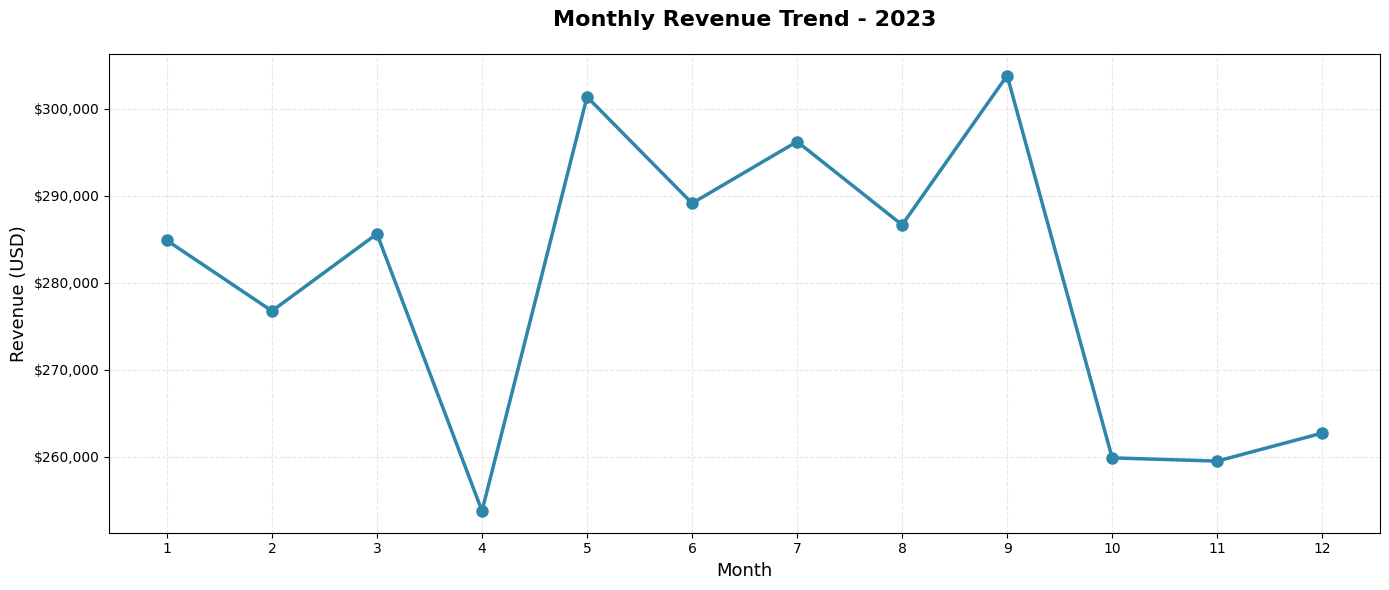


Monthly Revenue Breakdown for 2023:


,month,revenue,orders,avg_order_value,revenue_growth
0,1,284855.48,384,741.81,NaN
1,2,276758.54,384,720.73,-2.84
2,3,285618.77,394,724.92,3.20
3,4,253794.62,370,685.93,-11.14
4,5,301347.96,396,760.98,18.74
5,6,289126.72,406,712.13,-4.06
6,7,296209.39,392,755.64,2.45
7,8,286645.60,375,764.39,-3.23
8,9,303793.15,384,791.13,5.98
9,10,259890.15,379,685.73,-14.45


In [8]:
# Visualize monthly revenue trend
visualizer = MetricsVisualizer(business_report)
revenue_fig = visualizer.plot_revenue_trend(figsize=(14, 6))
plt.show()

# Display monthly trends table
monthly_trends = business_report['monthly_trends']
print(f"\nMonthly Revenue Breakdown for {ANALYSIS_YEAR}:")
display(monthly_trends[['month', 'revenue', 'orders', 'avg_order_value', 'revenue_growth']].round(2))

In [9]:
# Monthly performance insights
monthly_trends = business_report['monthly_trends']

best_month = monthly_trends.loc[monthly_trends['revenue'].idxmax()]
worst_month = monthly_trends.loc[monthly_trends['revenue'].idxmin()]
avg_monthly_growth = monthly_trends['revenue_growth'].mean()

print(f"Monthly Performance Insights:")
print(f"  Best Revenue Month: Month {int(best_month['month'])} (${best_month['revenue']:,.0f})")
print(f"  Lowest Revenue Month: Month {int(worst_month['month'])} (${worst_month['revenue']:,.0f})")
print(f"  Average Monthly Growth: {avg_monthly_growth:.2f}%")
print(f"  Revenue Volatility (Std Dev): ${monthly_trends['revenue'].std():,.0f}")

Monthly Performance Insights:
  Best Revenue Month: Month 9 ($303,793)
  Lowest Revenue Month: Month 4 ($253,795)
  Average Monthly Growth: -0.39%
  Revenue Volatility (Std Dev): $17,285


<a id='product-analysis'></a>
### 5.2 Product Category Performance

Understanding which product categories drive the most revenue and identifying growth opportunities.

In [10]:
# Product category analysis
product_data = business_report['product_performance']

if 'error' not in product_data:
    print(f"TOP PRODUCT CATEGORIES - {ANALYSIS_YEAR}")
    print("=" * 70)
    
    top_categories = product_data['top_categories']
    
    # Display top categories
    print(f"\n{'Category':<30} {'Revenue':>15} {'Share':>10} {'Orders':>10}")
    print("-" * 70)
    for idx, row in top_categories.iterrows():
        print(f"{row['product_category_name']:<30} ${row['total_revenue']:>14,.0f} {row['revenue_share']:>9.1f}% {row['unique_orders']:>9,}")
    
    # Category insights
    total_categories = len(product_data['all_categories'])
    top_5_share = top_categories.head(5)['revenue_share'].sum()
    
    print(f"\nProduct Category Insights:")
    print(f"  Total Product Categories: {total_categories}")
    print(f"  Top 5 Categories Revenue Share: {top_5_share:.1f}%")
    print(f"  Market Concentration: {'High' if top_5_share > 70 else 'Moderate' if top_5_share > 50 else 'Diversified'}")
else:
    print("Product category data not available for analysis")

TOP PRODUCT CATEGORIES - 2023

Category                               Revenue      Share     Orders
----------------------------------------------------------------------
electronics                    $     1,401,359      41.7%     1,227
home_garden                    $       862,653      25.7%     1,045
sports_outdoors                $       278,845       8.3%       645
automotive                     $       247,707       7.4%       473
clothing_shoes_jewelry         $       232,745       6.9%       828
toys_games                     $        70,164       2.1%       461
health_personal_care           $        65,370       1.9%       613
tools_home_improvement         $        54,280       1.6%       213
beauty_personal_care           $        49,213       1.5%       309
books_media                    $        38,559       1.1%       687

Product Category Insights:
  Total Product Categories: 13
  Top 5 Categories Revenue Share: 90.0%
  Market Concentration: High


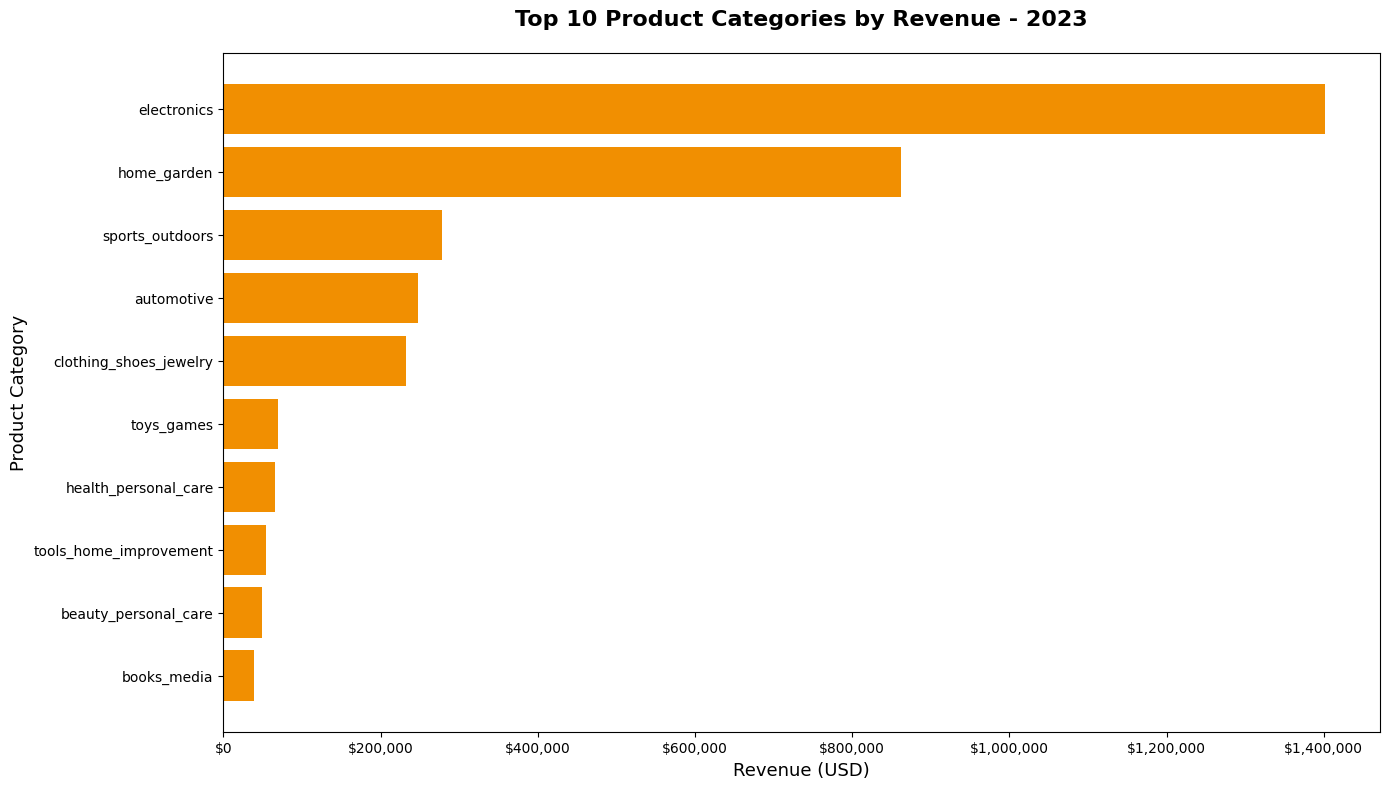

In [11]:
# Visualize category performance
if 'error' not in product_data:
    category_fig = visualizer.plot_category_performance(top_n=10, figsize=(14, 8))
    plt.show()

<a id='geographic-analysis'></a>
### 5.3 Geographic Performance Analysis

Analyzing sales performance across different geographic regions to identify market opportunities and regional trends.

In [12]:
# Geographic analysis
geo_data = business_report['geographic_performance']

if 'error' not in geo_data.columns:
    print(f"GEOGRAPHIC PERFORMANCE - {ANALYSIS_YEAR}")
    print("=" * 70)
    
    # Display top 10 states
    top_states = geo_data.head(10)
    print(f"\n{'State':<8} {'Revenue':>15} {'Orders':>10} {'Avg Order Value':>18}")
    print("-" * 70)
    for idx, row in top_states.iterrows():
        print(f"{row['state']:<8} ${row['revenue']:>14,.0f} {row['orders']:>9,} ${row['avg_order_value']:>17,.0f}")
    
    # Geographic insights
    total_states = len(geo_data)
    top_5_revenue = top_states.head(5)['revenue'].sum()
    total_revenue = geo_data['revenue'].sum()
    top_5_share = (top_5_revenue / total_revenue) * 100
    
    highest_aov_state = geo_data.loc[geo_data['avg_order_value'].idxmax()]
    
    print(f"\nGeographic Insights:")
    print(f"  States with Sales: {total_states}")
    print(f"  Top 5 States Revenue Share: {top_5_share:.1f}%")
    print(f"  Highest AOV State: {highest_aov_state['state']} (${highest_aov_state['avg_order_value']:,.0f})")
else:
    print("Geographic data not available for analysis")

GEOGRAPHIC PERFORMANCE - 2023

State            Revenue     Orders    Avg Order Value
----------------------------------------------------------------------
CA       $       537,881       769 $              699
TX       $       403,303       561 $              719
FL       $       310,196       431 $              720
NY       $       253,112       384 $              659
IL       $       185,931       260 $              715
PA       $       173,261       225 $              770
OH       $       157,620       200 $              788
GA       $       146,415       190 $              771
MI       $       132,326       210 $              630
NC       $       128,315       177 $              725

Geographic Insights:
  States with Sales: 20
  Top 5 States Revenue Share: 50.3%
  Highest AOV State: IN ($814)


In [13]:
# Visualize geographic heatmap
if 'error' not in geo_data.columns:
    geo_fig = visualizer.plot_geographic_heatmap()
    geo_fig.show()

<a id='customer-analysis'></a>
### 5.4 Customer Experience Analysis

Evaluating customer satisfaction through review scores and delivery performance metrics.

In [14]:
# Customer satisfaction analysis
satisfaction_metrics = business_report['customer_satisfaction']

if 'error' not in satisfaction_metrics:
    print(f"CUSTOMER SATISFACTION ANALYSIS - {ANALYSIS_YEAR}")
    print("=" * 70)
    print(f"\nReview Score Metrics:")
    print(f"  Average Review Score: {satisfaction_metrics['avg_review_score']:.2f}/5.0")
    print(f"  Total Reviews: {satisfaction_metrics['total_reviews']:,}")
    print(f"  5-Star Reviews: {satisfaction_metrics['score_5_percentage']:.1f}%")
    print(f"  4+ Star Reviews: {satisfaction_metrics['score_4_plus_percentage']:.1f}%")
    print(f"  Low Satisfaction (1-2 stars): {satisfaction_metrics['score_1_2_percentage']:.1f}%")
    
    # Satisfaction level assessment
    avg_score = satisfaction_metrics['avg_review_score']
    if avg_score >= 4.5:
        satisfaction_level = 'Excellent'
    elif avg_score >= 4.0:
        satisfaction_level = 'Good'
    elif avg_score >= 3.5:
        satisfaction_level = 'Fair'
    else:
        satisfaction_level = 'Needs Improvement'
    
    print(f"\nOverall Satisfaction Level: {satisfaction_level}")
else:
    print("Customer satisfaction data not available for analysis")

CUSTOMER SATISFACTION ANALYSIS - 2023

Review Score Metrics:
  Average Review Score: 4.10/5.0
  Total Reviews: 3,225
  5-Star Reviews: 34.7%
  4+ Star Reviews: 51.6%
  Low Satisfaction (1-2 stars): 7.2%

Overall Satisfaction Level: Good


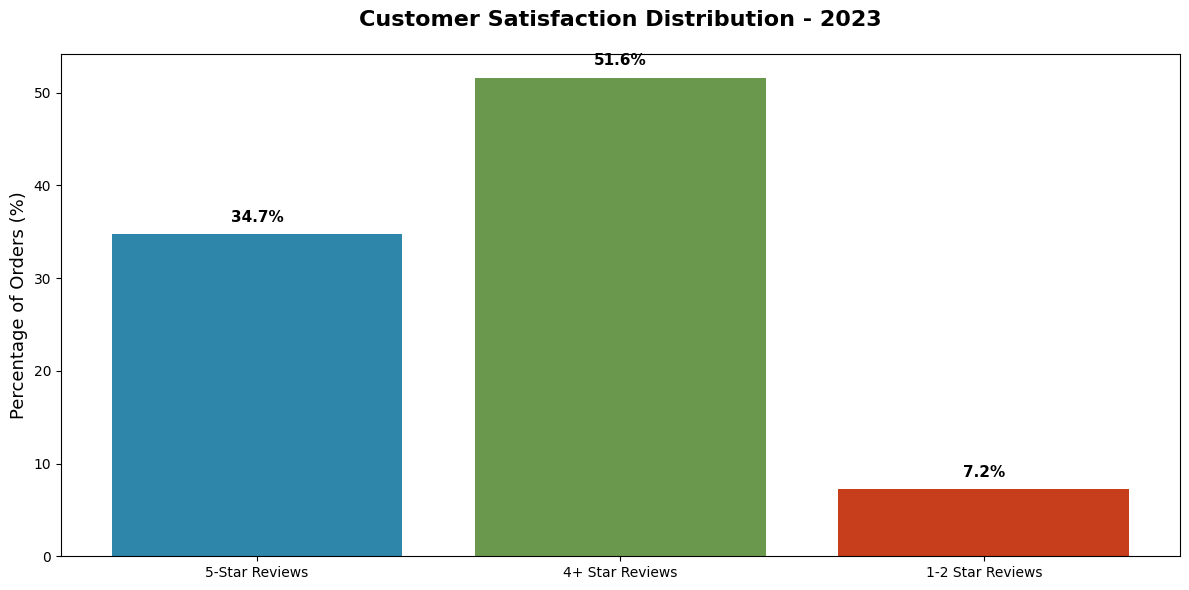

In [15]:
# Visualize review distribution
if 'error' not in satisfaction_metrics:
    review_fig = visualizer.plot_review_distribution(figsize=(12, 6))
    plt.show()

In [16]:
# Delivery performance analysis
delivery_metrics = business_report['delivery_performance']

if 'error' not in delivery_metrics:
    print(f"DELIVERY PERFORMANCE ANALYSIS - {ANALYSIS_YEAR}")
    print("=" * 70)
    print(f"\nDelivery Time Metrics:")
    print(f"  Average Delivery Time: {delivery_metrics['avg_delivery_days']:.1f} days")
    print(f"  Median Delivery Time: {delivery_metrics['median_delivery_days']:.1f} days")
    print(f"  Fast Delivery (3 days or less): {delivery_metrics['fast_delivery_percentage']:.1f}%")
    print(f"  Slow Delivery (over 7 days): {delivery_metrics['slow_delivery_percentage']:.1f}%")
    
    # Delivery performance assessment
    avg_delivery = delivery_metrics['avg_delivery_days']
    if avg_delivery <= 3:
        delivery_rating = 'Excellent'
    elif avg_delivery <= 5:
        delivery_rating = 'Good'
    elif avg_delivery <= 7:
        delivery_rating = 'Fair'
    else:
        delivery_rating = 'Needs Improvement'
    
    print(f"\nDelivery Performance Rating: {delivery_rating}")
else:
    print("Delivery performance data not available for analysis")

DELIVERY PERFORMANCE ANALYSIS - 2023

Delivery Time Metrics:
  Average Delivery Time: 8.0 days
  Median Delivery Time: 8.0 days
  Fast Delivery (3 days or less): 7.2%
  Slow Delivery (over 7 days): 55.6%

Delivery Performance Rating: Needs Improvement


In [17]:
# Analyze relationship between delivery speed and satisfaction
if 'error' not in satisfaction_metrics and 'error' not in delivery_metrics:
    print(f"\nDelivery-Satisfaction Relationship:")
    print(f"  Average Review Score: {satisfaction_metrics['avg_review_score']:.2f}/5.0")
    print(f"  Average Delivery Time: {delivery_metrics['avg_delivery_days']:.1f} days")
    print(f"  Fast Delivery Rate: {delivery_metrics['fast_delivery_percentage']:.1f}%")
    
    # Analyze delivery speed categories with review scores
    from data_loader import categorize_delivery_speed
    
    delivery_satisfaction = sales_data_current.copy()
    delivery_satisfaction['delivery_category'] = delivery_satisfaction['delivery_days'].apply(categorize_delivery_speed)
    
    speed_review_analysis = delivery_satisfaction.groupby('delivery_category')['review_score'].agg(['mean', 'count']).round(2)
    print(f"\nReview Scores by Delivery Speed:")
    display(speed_review_analysis)


Delivery-Satisfaction Relationship:
  Average Review Score: 4.10/5.0
  Average Delivery Time: 8.0 days
  Fast Delivery Rate: 7.2%

Review Scores by Delivery Speed:


,mean,count
delivery_category,,
1-3 days,4.21,366
4-7 days,4.07,1969
8+ days,4.11,2861


In [18]:
# Order status distribution
status_dist = business_report['order_status_distribution']

if 'error' not in status_dist.columns:
    print(f"\nORDER STATUS DISTRIBUTION - {ANALYSIS_YEAR}")
    print("=" * 70)
    print(f"\n{'Order Status':<15} {'Percentage':>12}")
    print("-" * 30)
    for idx, row in status_dist.iterrows():
        print(f"{row['order_status']:<15} {row['percentage']:>11.2f}%")


ORDER STATUS DISTRIBUTION - 2023

Order Status      Percentage
------------------------------
delivered            100.00%


<a id='summary'></a>
## 6. Summary of Key Observations

### Executive Summary

This section provides a comprehensive summary of the analysis findings and strategic recommendations.

In [19]:
# Generate executive summary
print(f"EXECUTIVE SUMMARY - {ANALYSIS_YEAR} BUSINESS PERFORMANCE")
print("=" * 70)

# Financial performance
revenue_metrics = business_report['revenue_metrics']
print(f"\nFinancial Performance:")
print(f"  Total Revenue: ${revenue_metrics['total_revenue']:,.0f}")
print(f"  Total Orders: {revenue_metrics['total_orders']:,}")
print(f"  Average Order Value: ${revenue_metrics['average_order_value']:,.0f}")

if 'revenue_growth_rate' in revenue_metrics:
    growth_direction = "increased" if revenue_metrics['revenue_growth_rate'] > 0 else "decreased"
    print(f"  Revenue Growth: {growth_direction} by {abs(revenue_metrics['revenue_growth_rate']):.1f}% vs {COMPARISON_YEAR}")

# Product performance
if 'error' not in business_report['product_performance']:
    top_category = business_report['product_performance']['top_categories'].iloc[0]
    print(f"\nProduct Performance:")
    print(f"  Top Category: {top_category['product_category_name']}")
    print(f"  Top Category Revenue: ${top_category['total_revenue']:,.0f}")
    print(f"  Market Share: {top_category['revenue_share']:.1f}%")

# Geographic performance
geo_data = business_report['geographic_performance']
if 'error' not in geo_data.columns:
    top_state = geo_data.iloc[0]
    print(f"\nGeographic Performance:")
    print(f"  Top Market: {top_state['state']}")
    print(f"  Top Market Revenue: ${top_state['revenue']:,.0f}")
    print(f"  Active Markets: {len(geo_data)} states")

# Customer experience
if 'error' not in business_report['customer_satisfaction']:
    satisfaction = business_report['customer_satisfaction']
    print(f"\nCustomer Experience:")
    print(f"  Average Rating: {satisfaction['avg_review_score']:.1f}/5.0")
    print(f"  High Satisfaction Rate: {satisfaction['score_4_plus_percentage']:.0f}% (4+ stars)")

if 'error' not in business_report['delivery_performance']:
    delivery = business_report['delivery_performance']
    print(f"  Average Delivery Time: {delivery['avg_delivery_days']:.1f} days")
    print(f"  Fast Delivery Rate: {delivery['fast_delivery_percentage']:.0f}% (3 days or less)")

EXECUTIVE SUMMARY - 2023 BUSINESS PERFORMANCE

Financial Performance:
  Total Revenue: $3,360,295
  Total Orders: 4,635
  Average Order Value: $725
  Revenue Growth: decreased by 2.5% vs 2022

Product Performance:
  Top Category: electronics
  Top Category Revenue: $1,401,359
  Market Share: 41.7%

Geographic Performance:
  Top Market: CA
  Top Market Revenue: $537,881
  Active Markets: 20 states

Customer Experience:
  Average Rating: 4.1/5.0
  High Satisfaction Rate: 52% (4+ stars)
  Average Delivery Time: 8.0 days
  Fast Delivery Rate: 7% (3 days or less)


In [20]:
# Generate strategic recommendations
print("\n" + "=" * 70)
print("STRATEGIC RECOMMENDATIONS")
print("=" * 70)

recommendations = []

# Revenue-based recommendations
if 'revenue_growth_rate' in revenue_metrics:
    if revenue_metrics['revenue_growth_rate'] < 0:
        recommendations.append(
            "Address negative revenue growth through customer acquisition and retention initiatives"
        )
    elif revenue_metrics['revenue_growth_rate'] < 5:
        recommendations.append(
            "Accelerate growth through market expansion and product diversification"
        )

# Product recommendations
if 'error' not in business_report['product_performance']:
    top_5_share = business_report['product_performance']['top_categories'].head(5)['revenue_share'].sum()
    if top_5_share > 70:
        recommendations.append(
            "Diversify product portfolio to reduce dependency on top categories"
        )

# Customer experience recommendations
if 'error' not in business_report['customer_satisfaction']:
    satisfaction = business_report['customer_satisfaction']
    if satisfaction['avg_review_score'] < 4.0:
        recommendations.append(
            "Implement quality improvements to enhance customer satisfaction scores"
        )
    if satisfaction['score_1_2_percentage'] > 10:
        recommendations.append(
            "Investigate and address root causes of low satisfaction ratings"
        )

# Delivery recommendations
if 'error' not in business_report['delivery_performance']:
    delivery = business_report['delivery_performance']
    if delivery['avg_delivery_days'] > 7:
        recommendations.append(
            "Optimize logistics operations to reduce average delivery time"
        )
    if delivery['fast_delivery_percentage'] < 20:
        recommendations.append(
            "Invest in fast delivery capabilities to improve competitive position"
        )

# Geographic recommendations
if 'error' not in geo_data.columns:
    if len(geo_data) < 30:
        recommendations.append(
            "Explore expansion opportunities in underserved geographic markets"
        )

# Display recommendations
if recommendations:
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec}")
else:
    print("\nBusiness performance is strong across all analyzed metrics")

print("\n" + "=" * 70)
print(f"Analysis completed for {ANALYSIS_YEAR}")
if COMPARISON_YEAR:
    print(f"Comparison baseline: {COMPARISON_YEAR}")
print(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)


STRATEGIC RECOMMENDATIONS

1. Address negative revenue growth through customer acquisition and retention initiatives

2. Diversify product portfolio to reduce dependency on top categories

3. Optimize logistics operations to reduce average delivery time

4. Invest in fast delivery capabilities to improve competitive position

5. Explore expansion opportunities in underserved geographic markets

Analysis completed for 2023
Comparison baseline: 2022
Generated: 2025-10-07 12:37:54


---

## Analysis Configuration Summary

This notebook provides a comprehensive, configurable framework for e-commerce business analysis.

### Key Features

- **Configurable Time Periods**: Easily adjust analysis and comparison years/months
- **Modular Architecture**: Reusable data loading and metrics calculation modules
- **Comprehensive Metrics**: Revenue, product, geographic, and customer experience analysis
- **Professional Visualizations**: Business-oriented charts with proper formatting
- **Strategic Insights**: Data-driven recommendations based on performance metrics

### How to Use

1. **Configure Analysis Parameters**: Modify ANALYSIS_YEAR, COMPARISON_YEAR, and ANALYSIS_MONTH at the top
2. **Run All Cells**: Execute the notebook to generate the complete analysis
3. **Review Outputs**: Examine metrics, visualizations, and recommendations
4. **Export Results**: Save visualizations and tables for reporting

### Extending the Analysis

- Add new metrics in the `business_metrics.py` module
- Customize visualizations in the `MetricsVisualizer` class
- Modify data loading logic in `data_loader.py` for different data sources
- Create additional analysis sections as needed

---